In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Winding Dataset

Dataset Original Length n:  2499
Dataset Sampled Length n:  2499


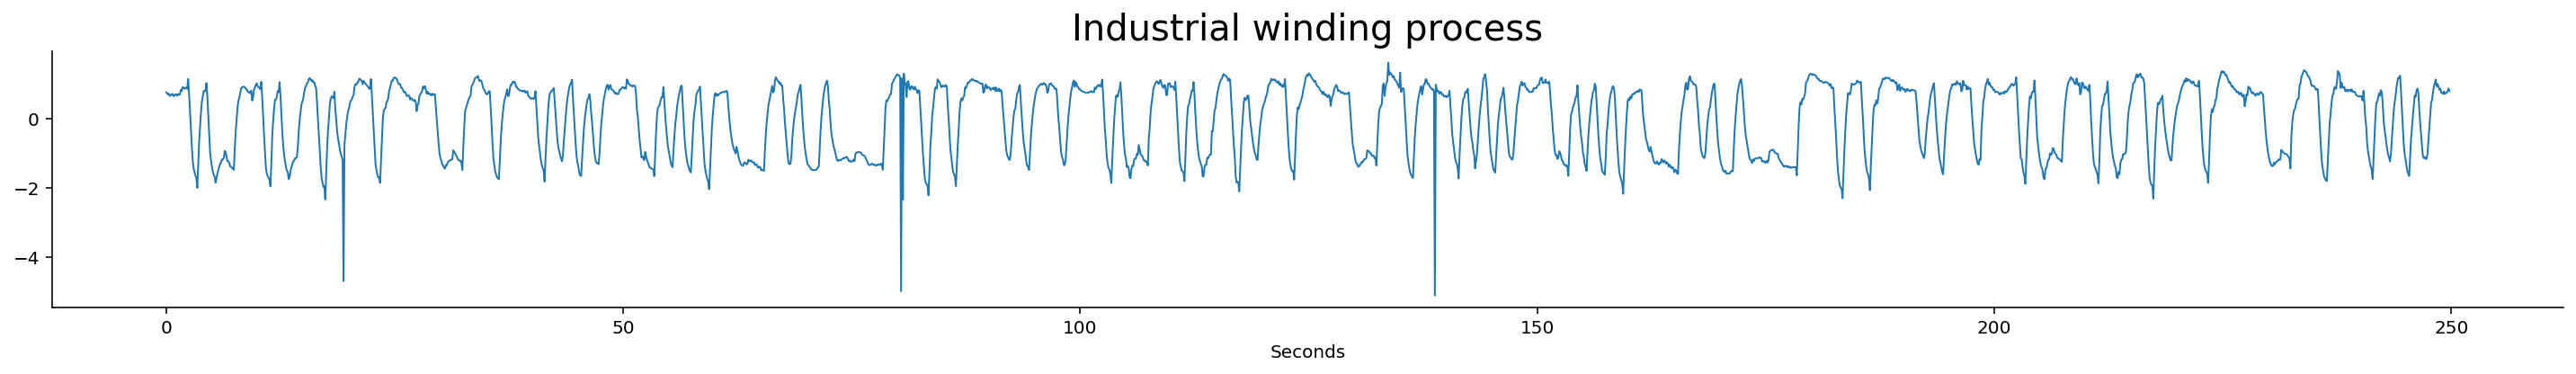

In [2]:
file = "winding_col.csv"
ds_name = "Industrial winding process"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, len(data), 1) / 10, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = False
motif_length = 60
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/winding_col.csv


# k-Motiflets

## First, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.06it/s]


Chosen window-size: 60
Identified Elbow Points [ 3  6 10]
Filtered Elbow Points [6, 10]


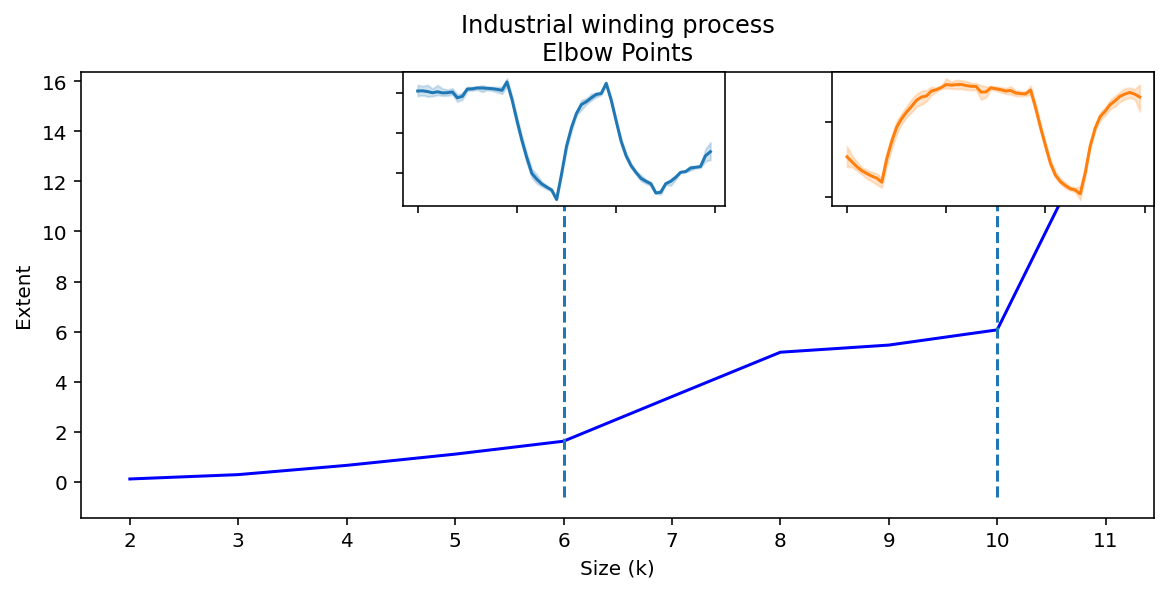

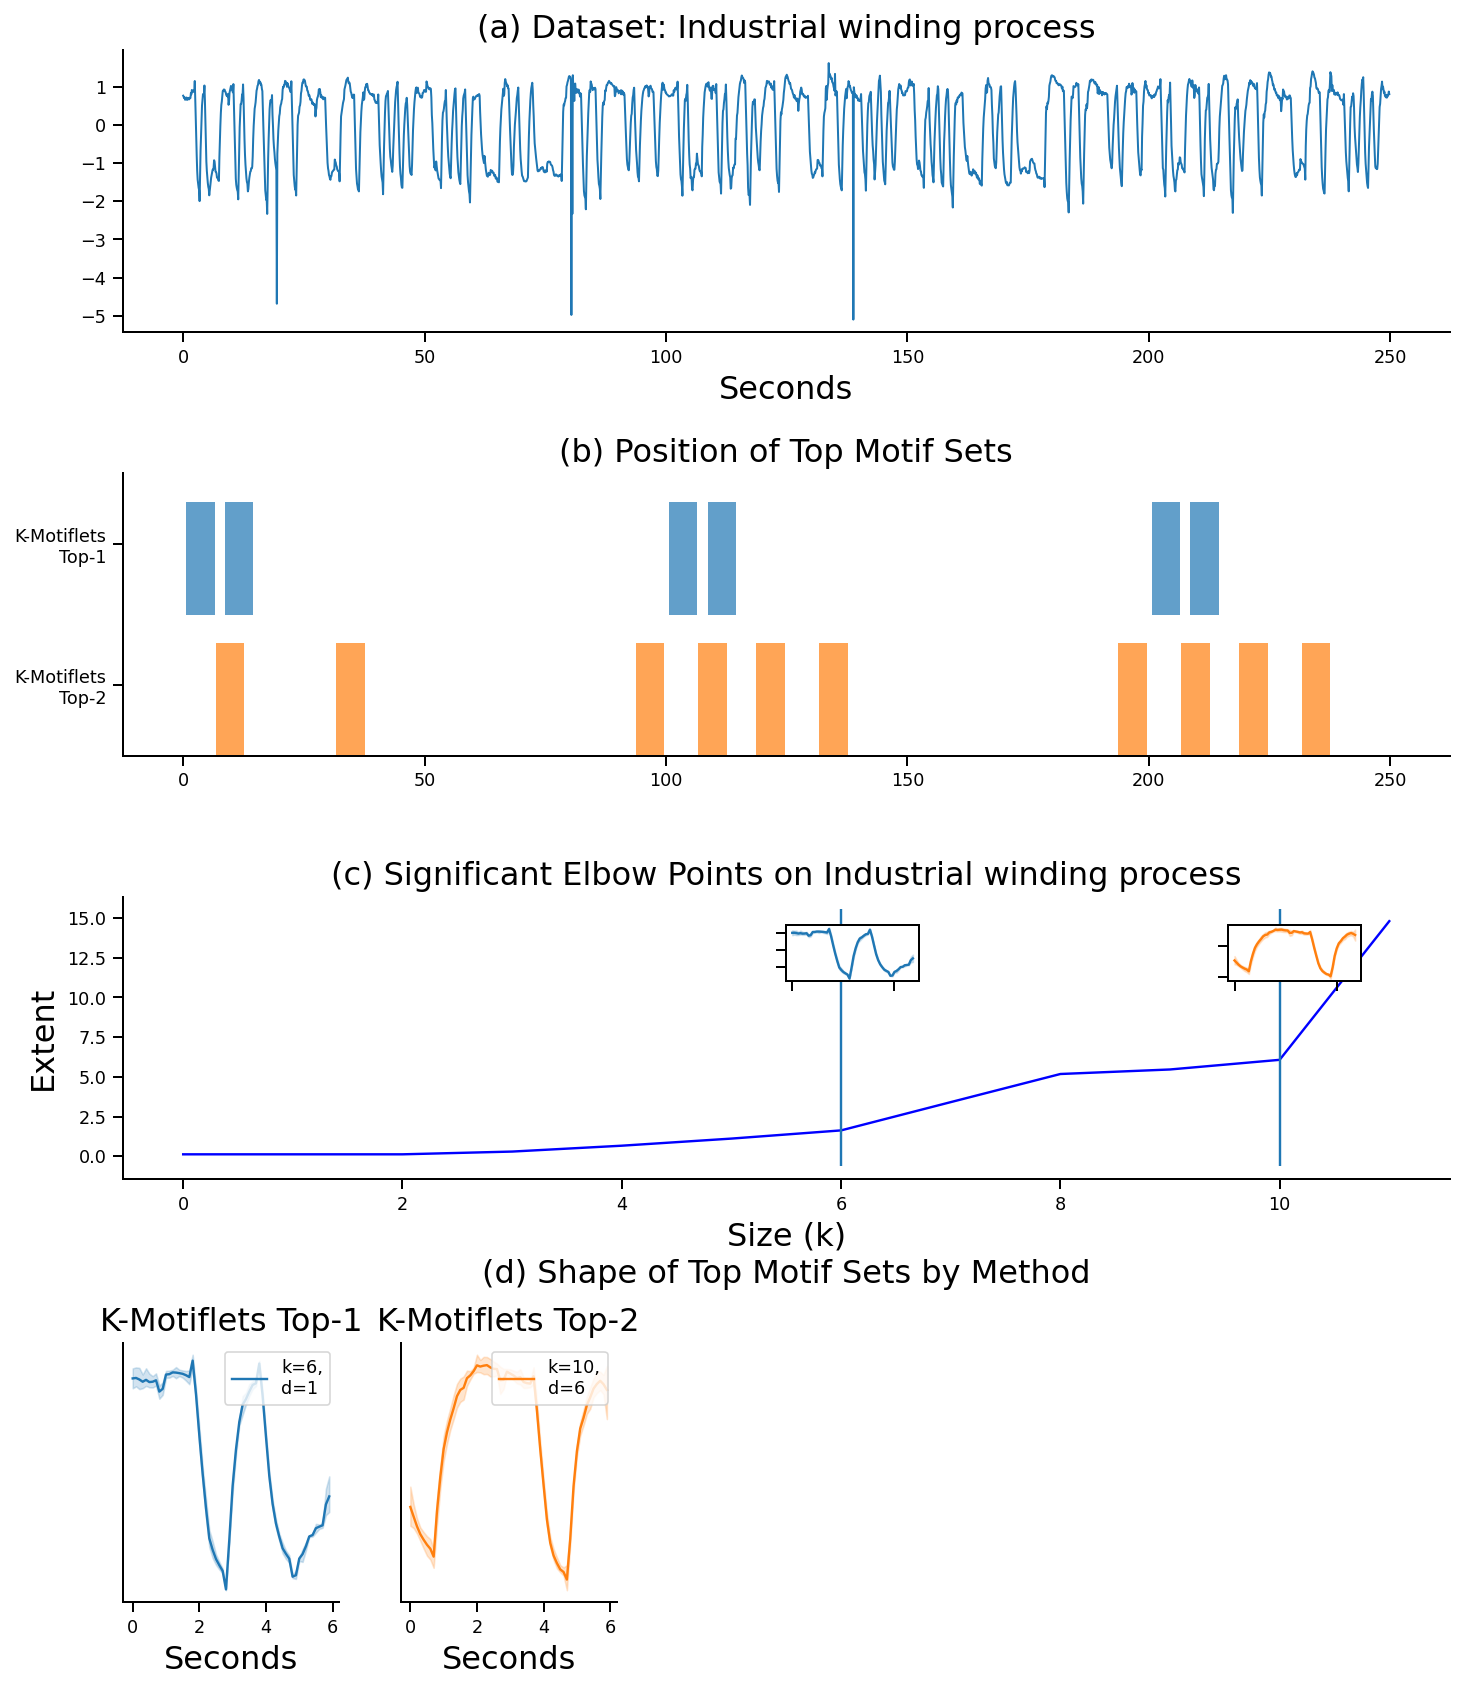

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    12, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets")

In [5]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 4.324788570404053 0.9148634672164917
Extent d of TOP-1 Motif 6.073066234588623


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But this oracle is off by just 11% on both parameters to reflect human trial-and-error.

In [6]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

# Human error due to trial-and-error
error = 0.11

rs = radii * (1.0*(1-error))
mls = np.int32(motif_length * (1+error))

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

print("Radii with human error\t", rs)
print("Length with human error\t", mls)

Radii r [0.91486347 4.32478857]
Best Radii	 [0.91486347 4.32478857]
Best Lengths	 60
Radii with human error	 [0.81422849 3.84906183]
Length with human error	 66


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

r: 0.6318973302841187 d: 0.7522023320198059
r: 2.6318798065185547 d: 4.873908996582031
Filtered Elbow Points [0, 1]


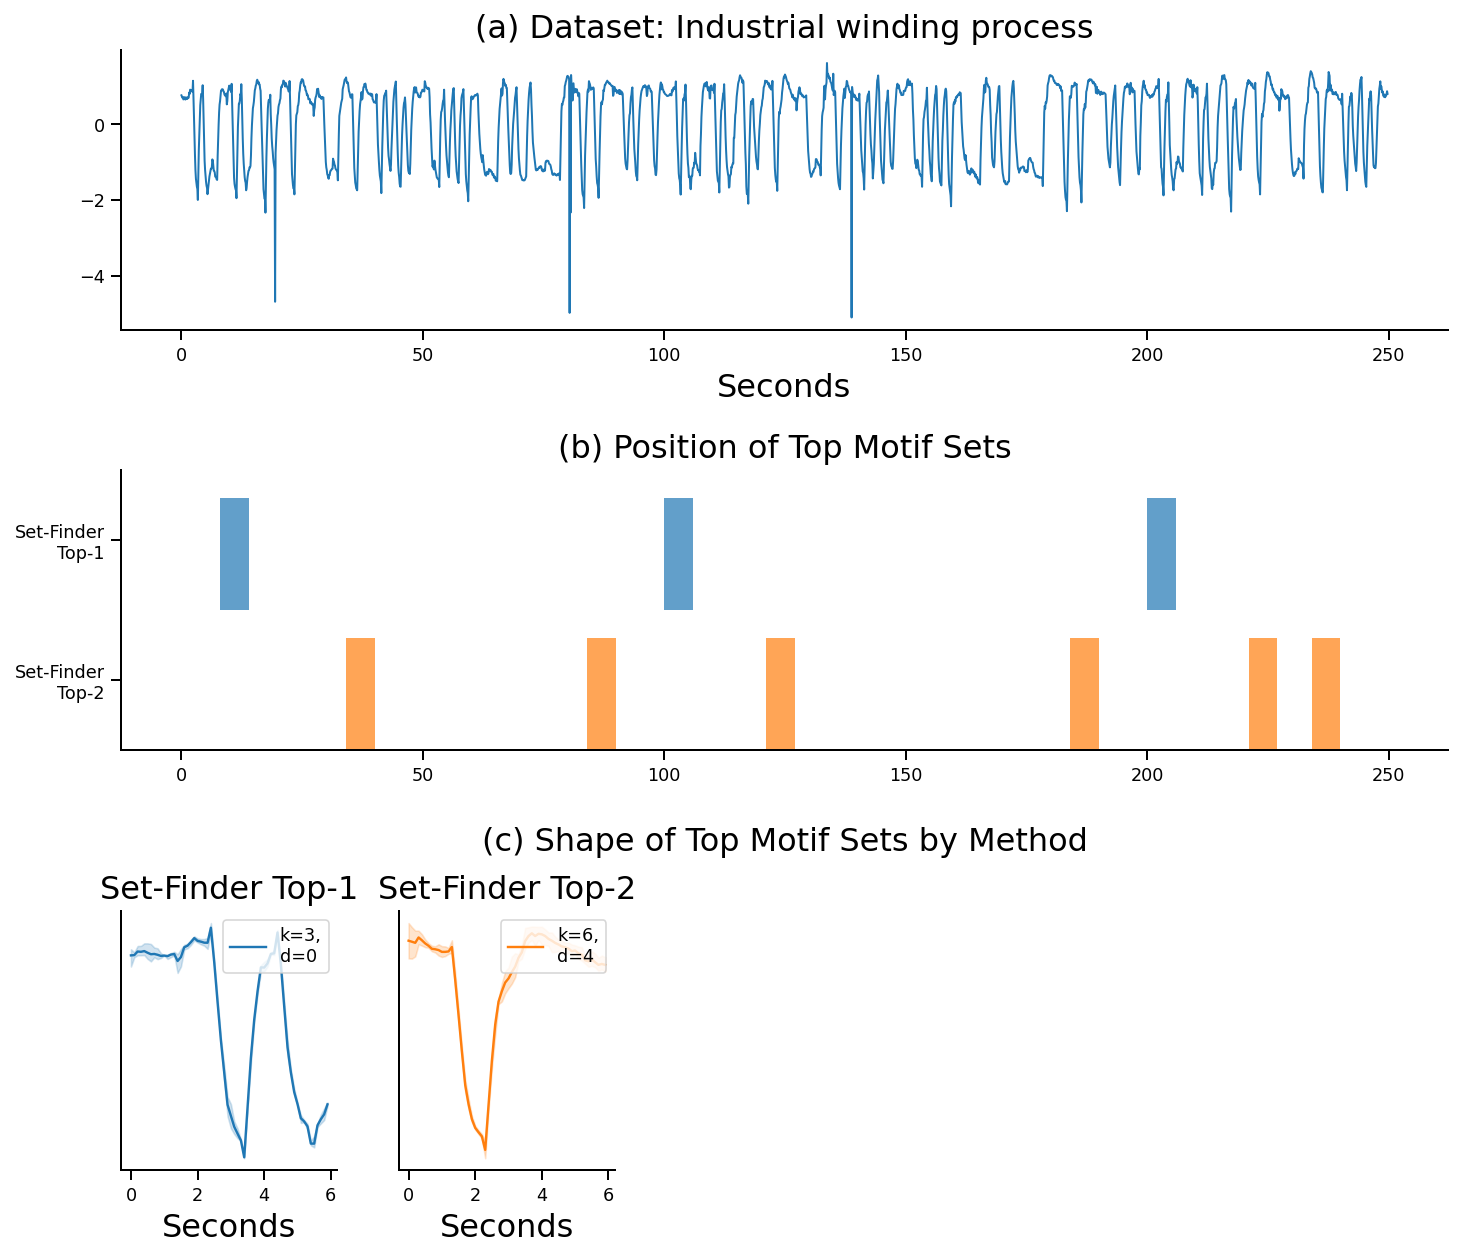

In [8]:
# run jave code first       
ms_set_finder = [
    [1000, 80, 2000],
	[1211, 341, 841, 1841, 2211, 2341], 
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

r: 0.7103232741355896 d: 0.7522023320198059
r: 3.0403151512145996 d: 5.086385726928711
Filtered Elbow Points [0, 1]


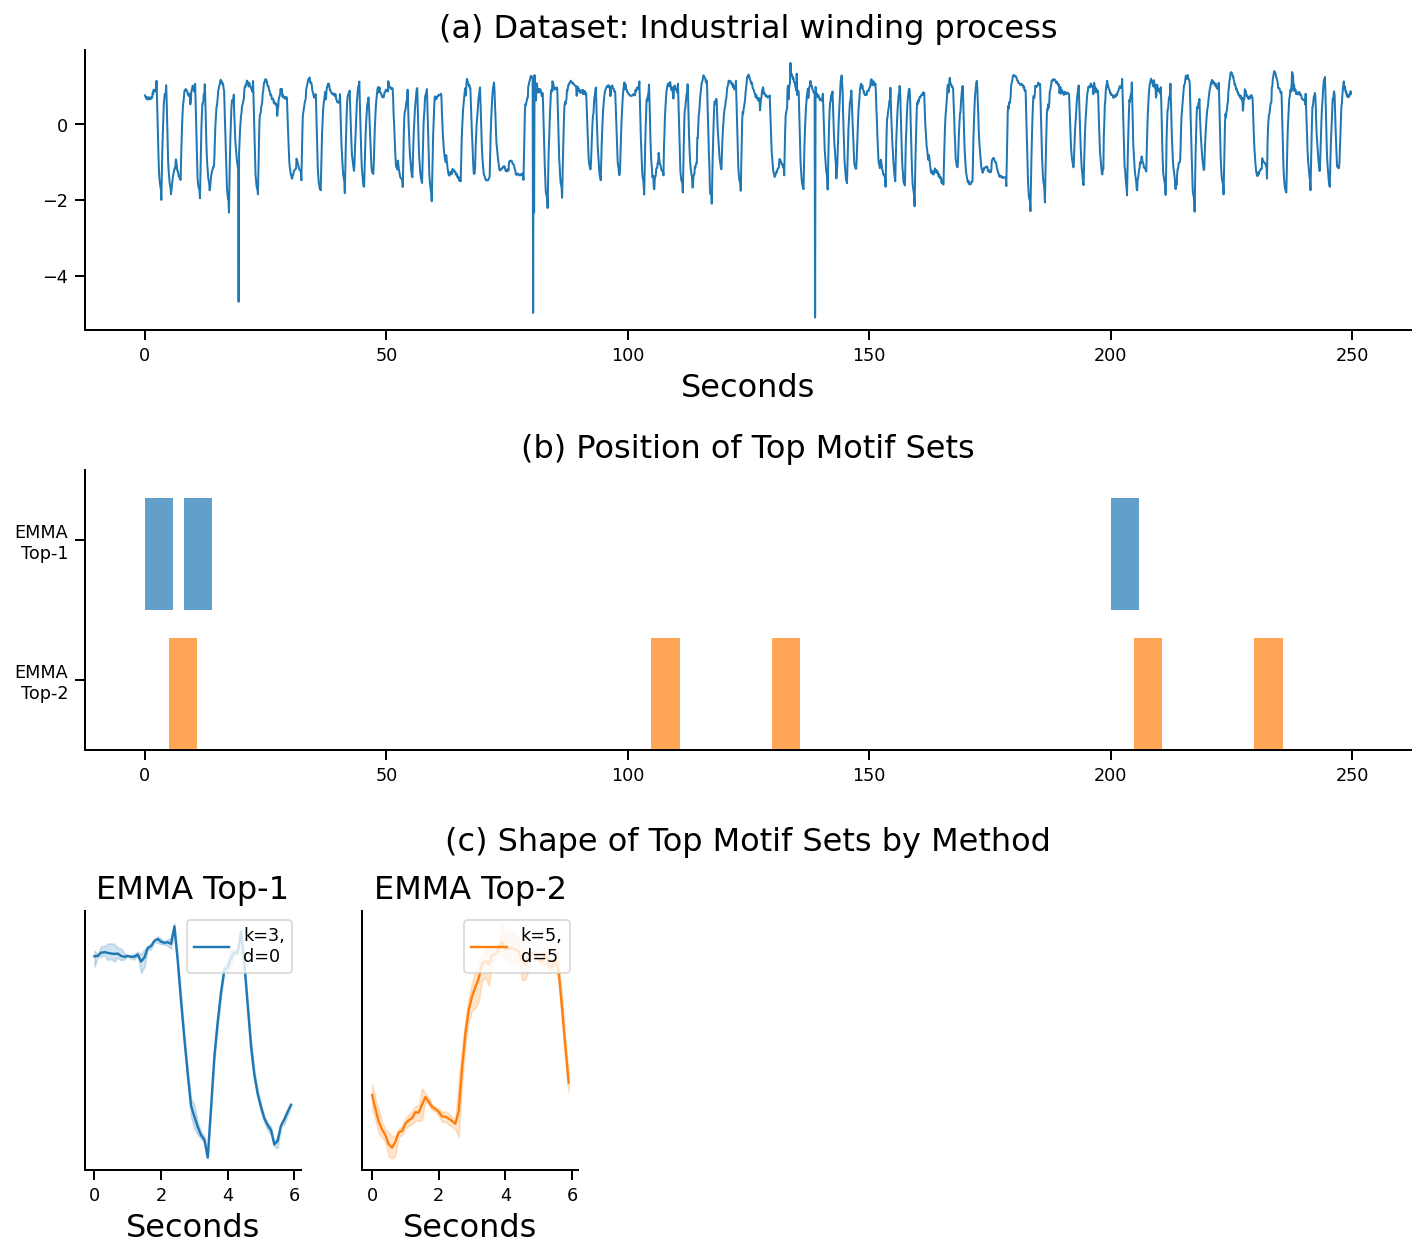

In [10]:
# run jave code first       
ms_emma = [
	[0, 80, 2000],
	[49, 1049, 1298, 2048, 2298],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Learning Motifs
See Java Code

In [11]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

r: 1.865348219871521 d: 2.7962265014648438
r: 3.8791744709014893 d: 4.3840532302856445
Filtered Elbow Points [0, 1]


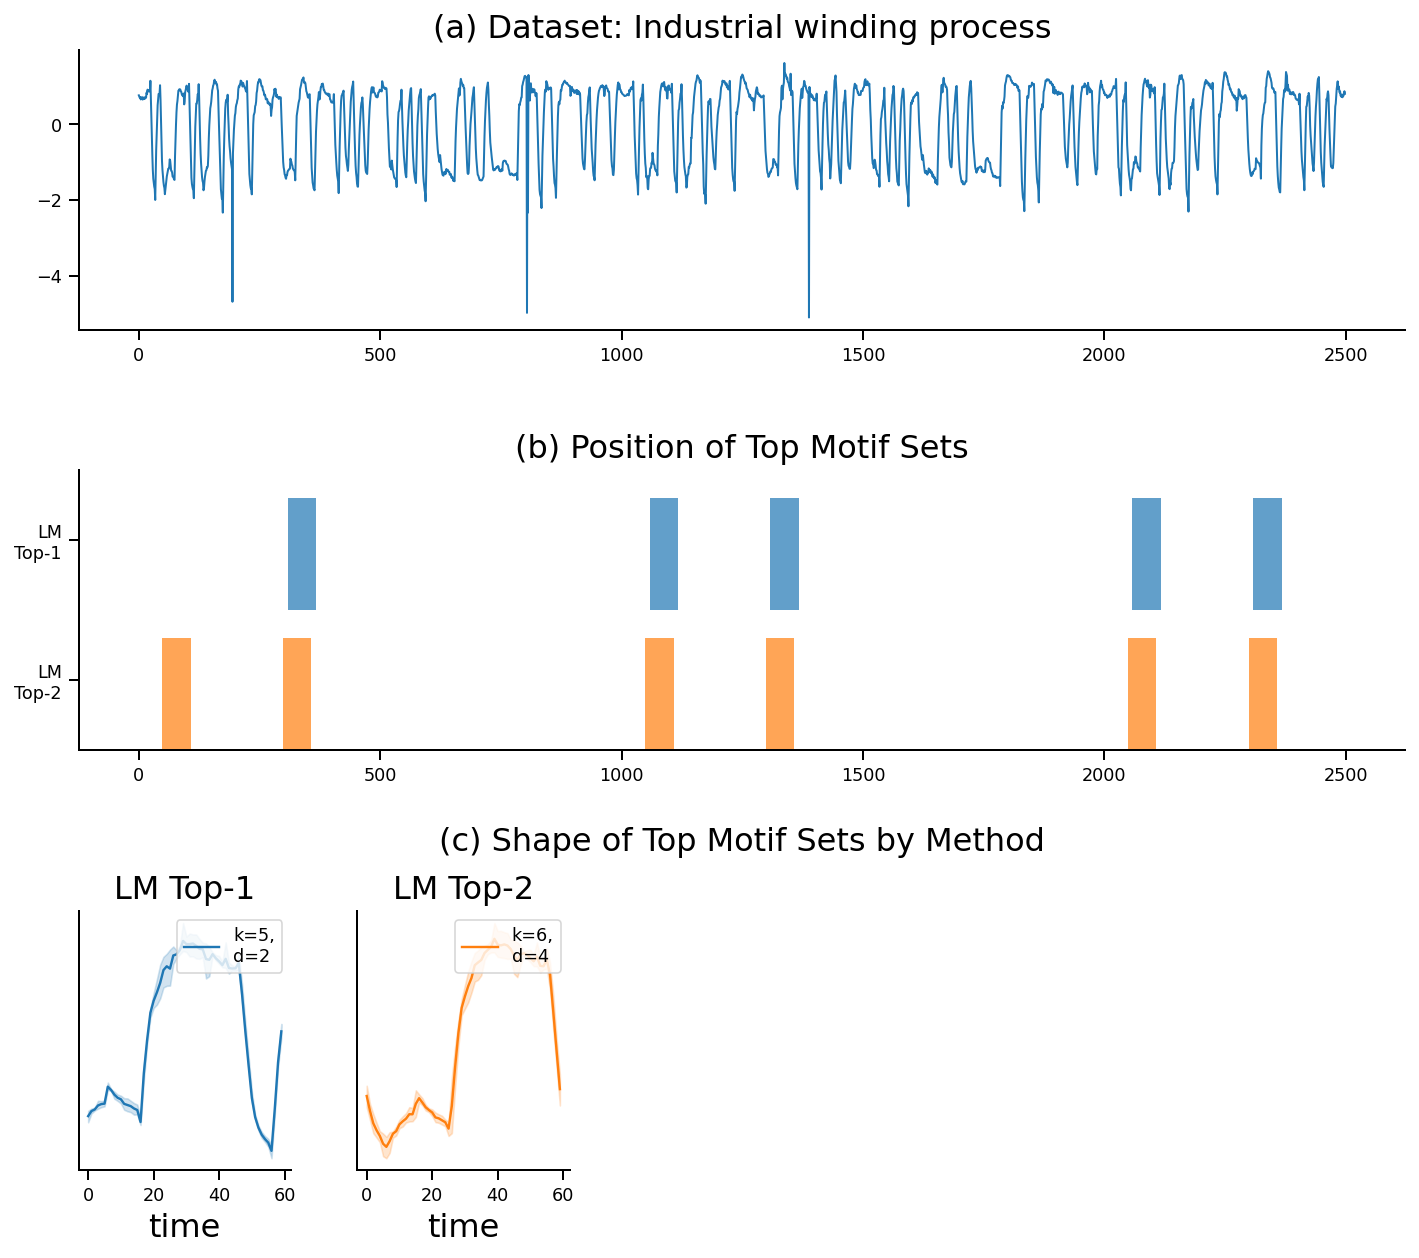

In [12]:
ms_learning_motifs = np.array([
	[308,1058,1308,2058,2308,],
	[49,298,1049,1298,2048,2299,],
])

    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 0.14599668979644775 d: 0.14599668979644775


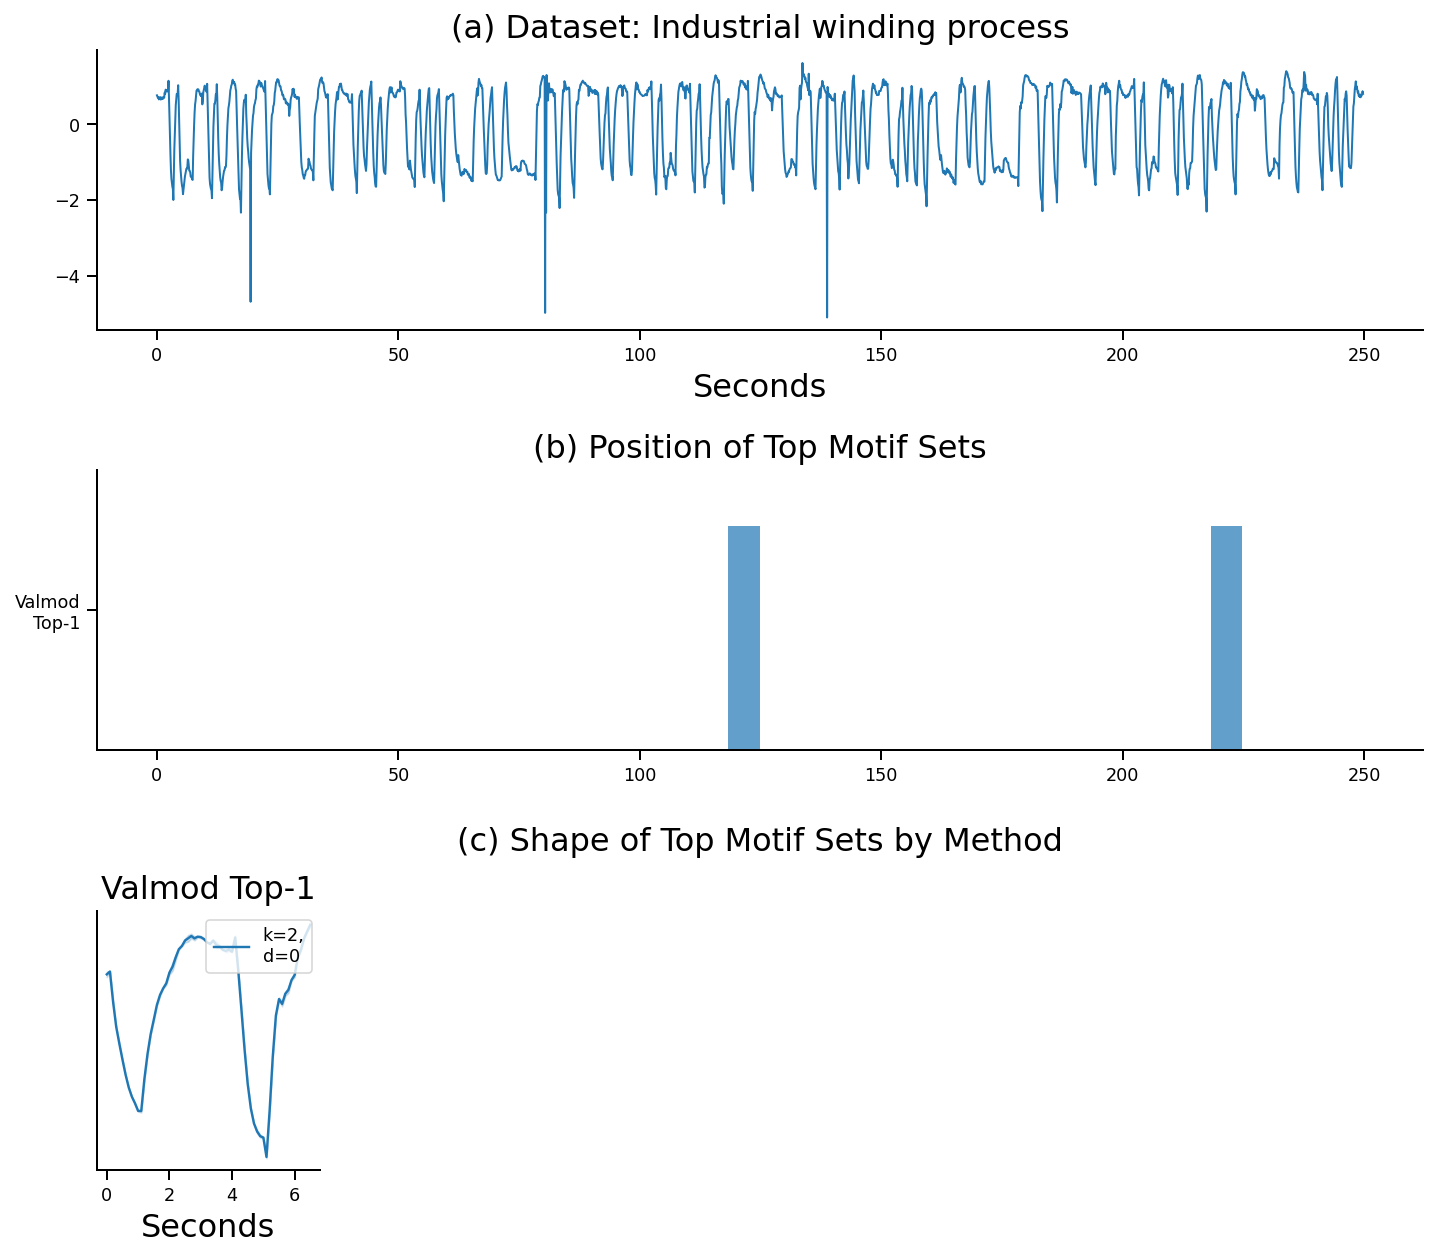

In [13]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs[-1]))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod", filter=False)

df["VALMOD Top-1"] = [motifset[-1]]
# Does not exist df2["VALMOD Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Comparison

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[317, 2317, 1317, 2067, 2187, 1067, 1187, 67, ..."
Set Finder Top-1,"[1211, 341, 841, 1841, 2211, 2341]"
EMMA Top-1,"[49, 1049, 1298, 2048, 2298]"
LM Top-1,"[49, 298, 1049, 1298, 2048, 2299]"
VALMOD Top-1,"[1183, 2183]"
Motiflets Top-2,"[6, 1006, 2006, 86, 1086, 2086]"
Set Finder Top-2,"[1000, 80, 2000]"
EMMA Top-2,"[0, 80, 2000]"
LM Top-2,"[308, 1058, 1308, 2058, 2308]"


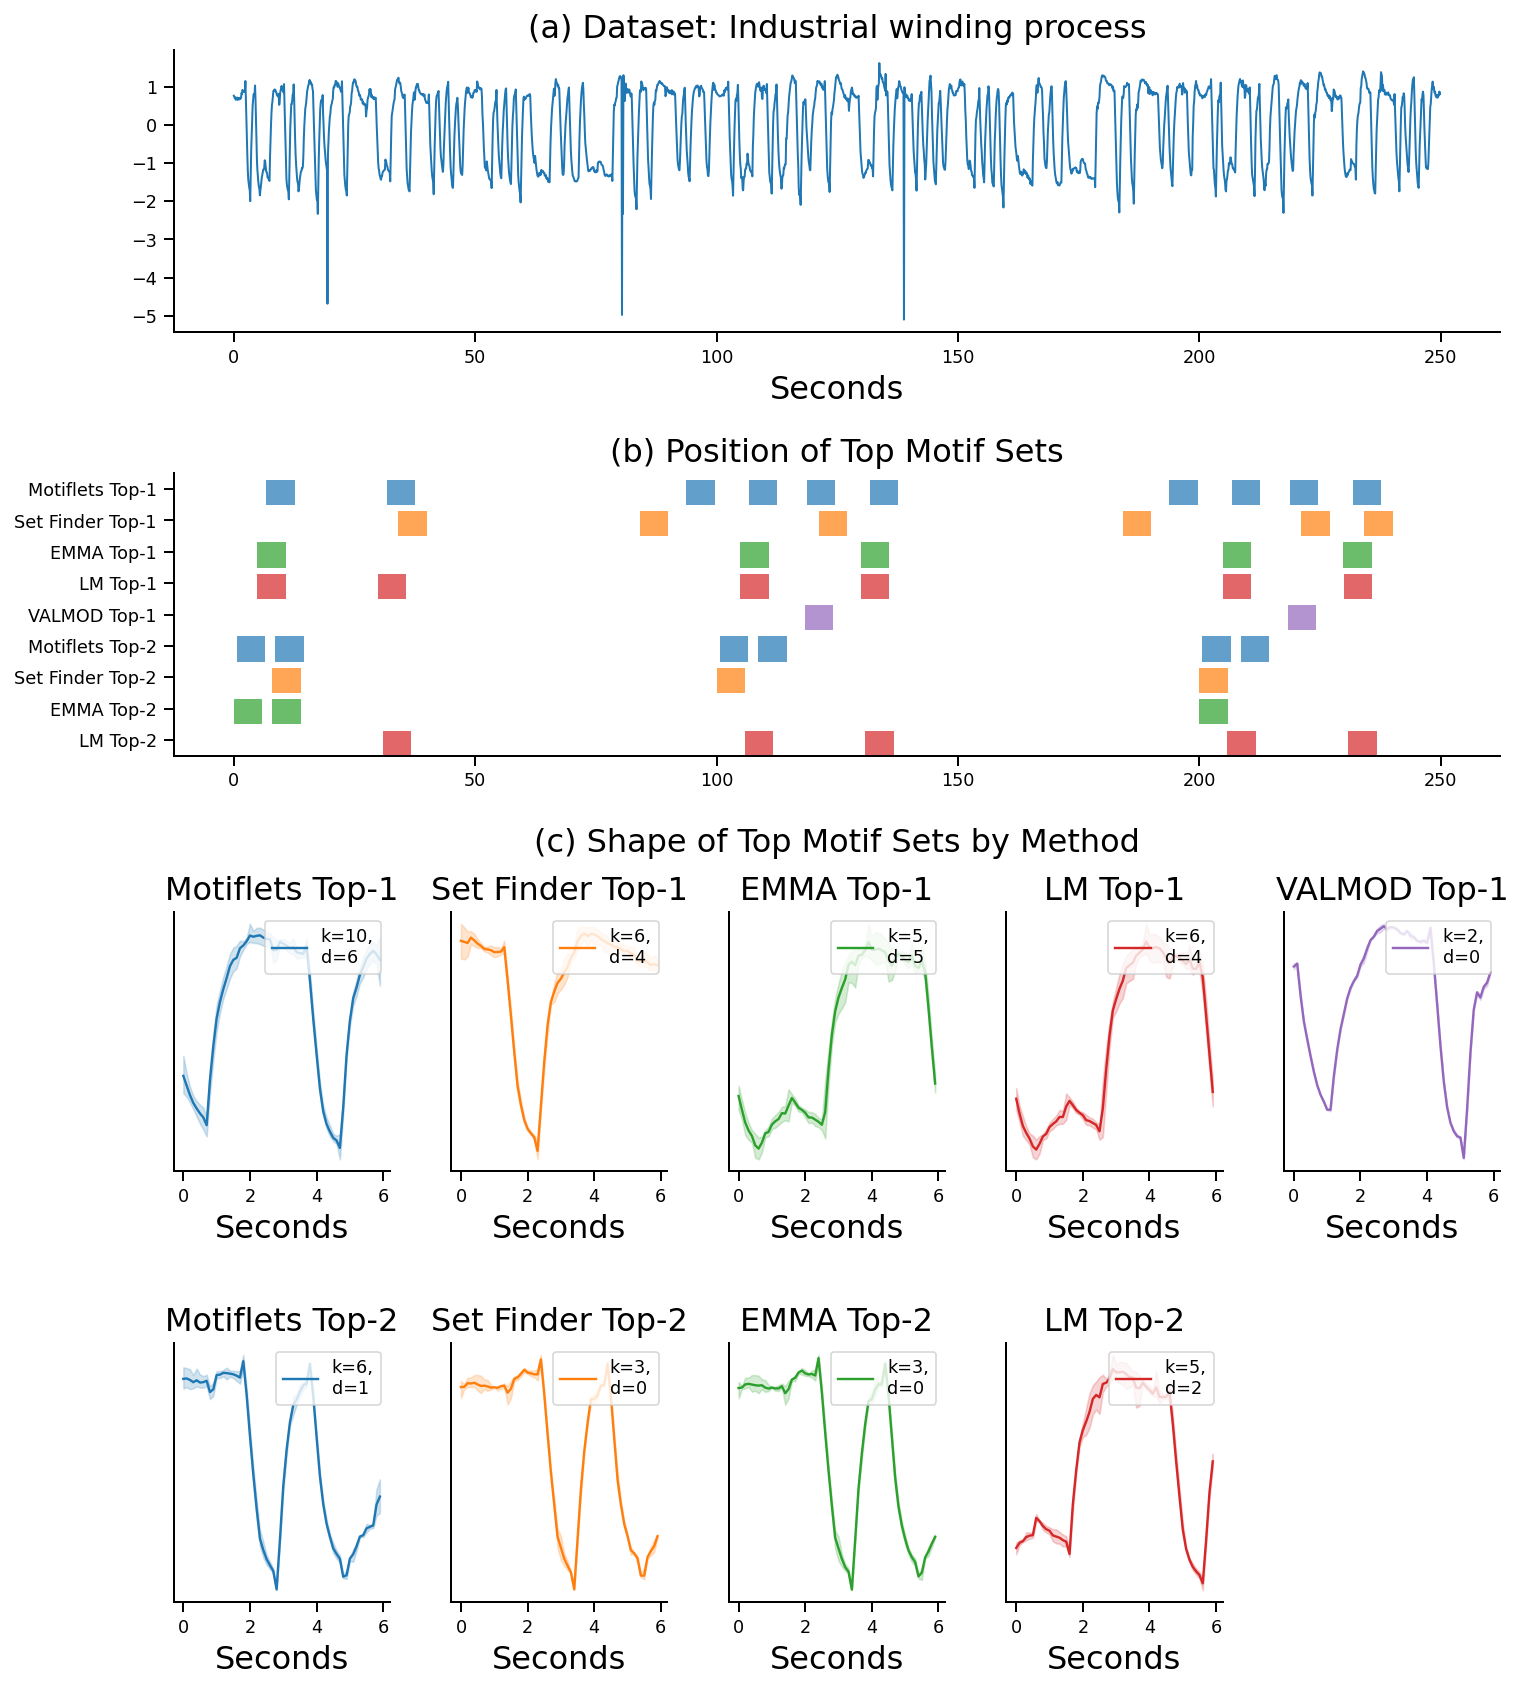

In [15]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)